In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from IPython.core.display import Image, display

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams['font.size'] = 12


## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2024

&nbsp;
&nbsp;
&nbsp;
# Lab 7. Principal Component Analysis

&nbsp;
&nbsp;
&nbsp;

**Jose Manuel de Frutos Porras and David Martínez Rubio**

**Adapted from a notebook by Ignacio Peis**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;



# 1. Introduction

PCA is an unsupervised learning method highly efficient for dimensionality reduction in a dataset. Denote by $N$ the number of samples of dimension $D$ in the dataset, i. e. $\mathbf{x}_{n}\in\mathbb{R}^D$, $n=1,\ldots,N$, with $\mathbf{x}^T_{n}=[x_{n1}, x_{n2}, \ldots, x_{nD}]$. For simplicity, we assume that the data has zero mean:

$$\overline{\mathbf{x}} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_{n}=\mathbf{0}$$

PCA perform a lineaer dimensionality reduction. For each datapoint $\bf x$, we compute a representation $\mathbf{z}\in\mathbb{R}^K$ in a $K$-dimensional space, where $K<D$, by means of a matrix multiplication:

$$ {\bf z} = [z_{1}, z_{2}, \ldots, z_{K}] = {\bf x}^T {\bf U}$$

where the transformation matrix $\bf U$ has dimensions $D\times K$

$${\bf U}=[\mathbf{u}_{1},\mathbf{u}_{2},\ldots,\mathbf{u}_{K}]$$

and $\mathbf{u}_{j}$, $j=1\ldots K$, are the columns of $\bf U$. Further, these columns are orthonormals:

$$\mathbf{u}_{j}^T\mathbf{u}_{j} = 1$$

$$\mathbf{u}_{j}^T\mathbf{u}_{j} = 0 ~~i \neq j$$


Upon these conditions, $z_{j}= {\bf x}^T \mathbf{u}_j$ is the **projection** of $\bf x$ over $\mathbf{u}_j$.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/proyeccionv3.jpeg' width=600 />

Finally, as $\bf U$ is composed by orthonormal columns, therefore $\bf UU^T=I$, given the vector $\bf z$, we can reconstruct in the $D$-dimensional data space in the form:

$$\tilde{\mathbf{x}} = \mathbf{U} {\bf z}^T  $$

In general, $\tilde{\mathbf{x}}\neq \mathbf{x}$, as reducing the dimensionality always leads to losing certain information. We can characterize this error by means of the square mean error:

$$J = \frac{1}{N}\sum_{n=1}^{D} ||\mathbf{x}_n - \tilde{\mathbf{x}}_n||^2_2 =\frac{1}{N}\sum_{n=1}^{D} ||\mathbf{x}_n - \mathbf{U}\mathbf{z}_n^T||^2_2$$


### Example in two dimensions

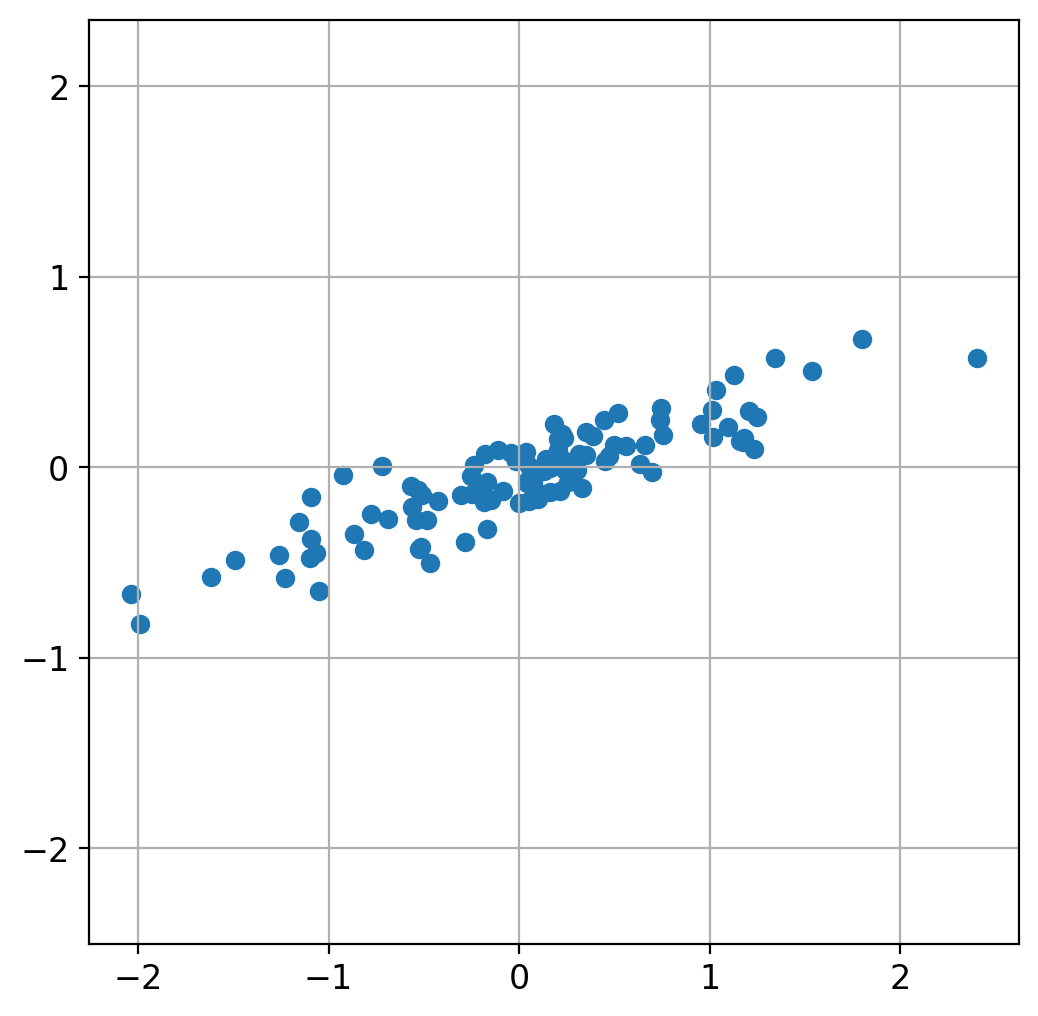

The reconstruction error is 0.16
The variance of the projected data in vector u is 0.56


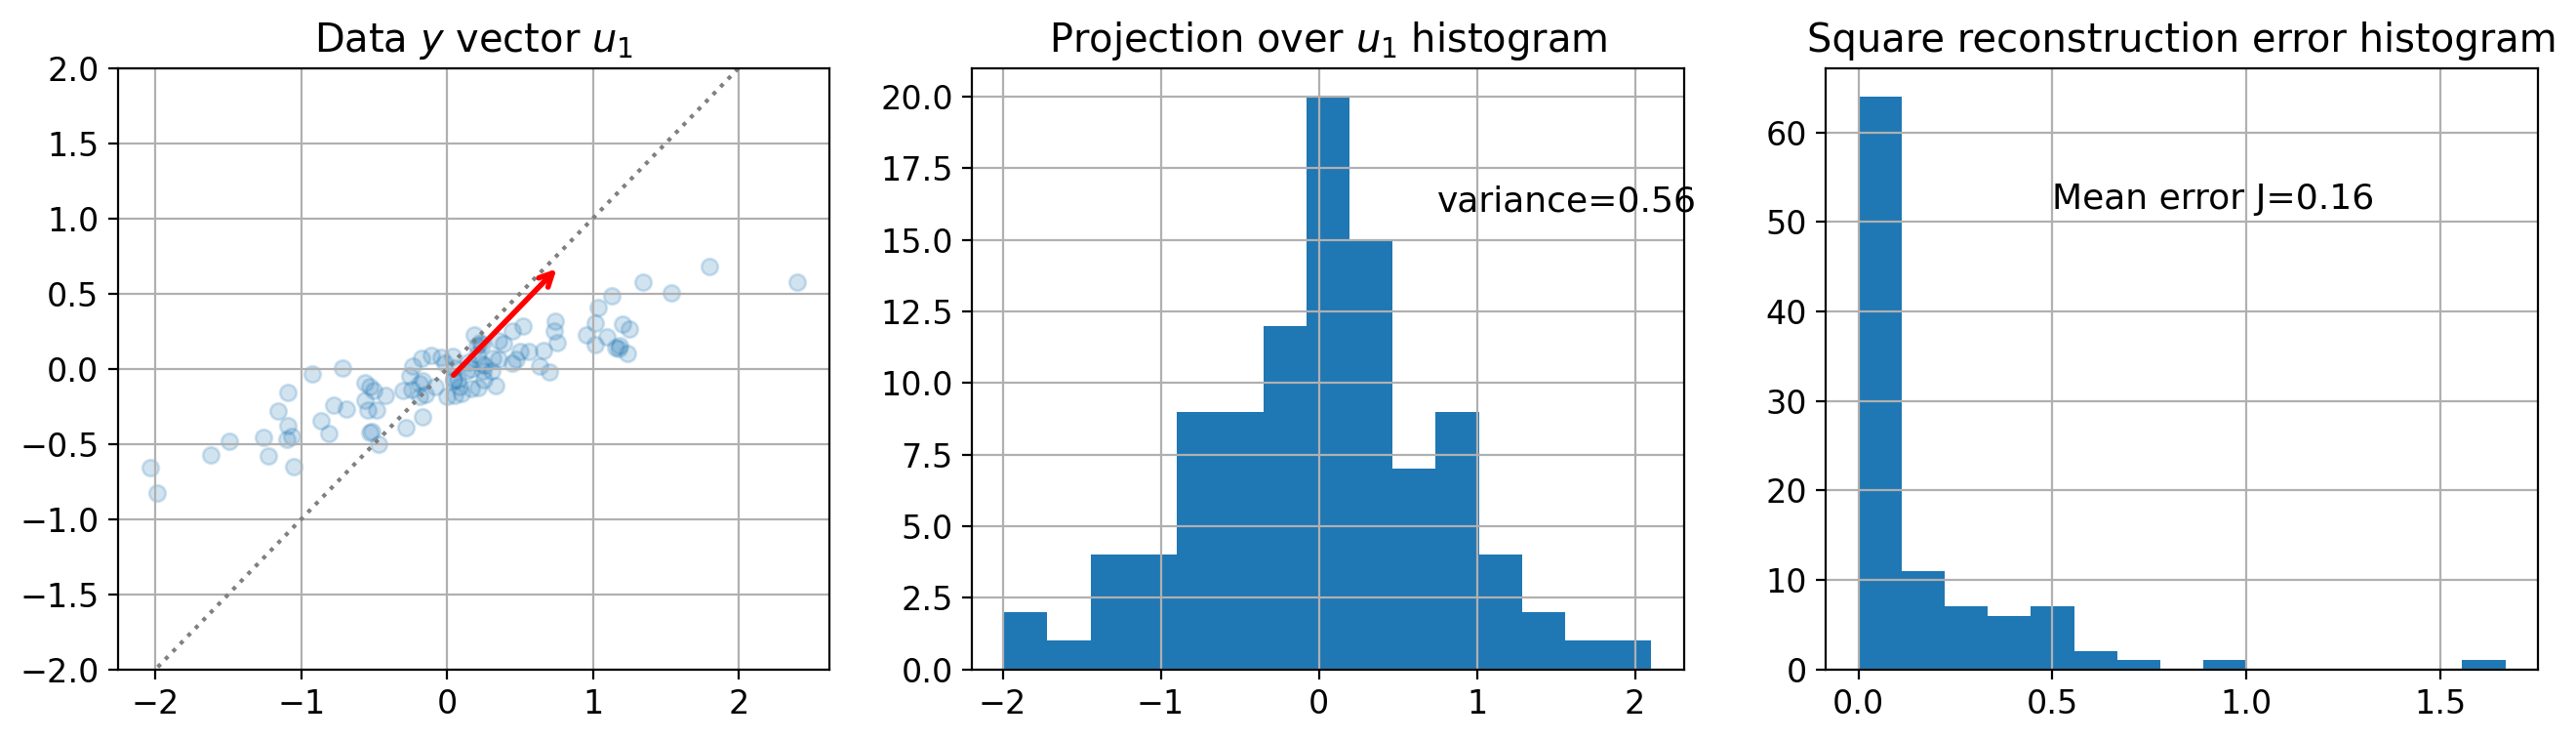

In [4]:
# Generate data
rng = np.random.RandomState(1)
A = rng.rand(2, 2)
X = (A@rng.randn(2, 100)).T
X = X - np.mean(X)  # We center the data.

plt.scatter(X[:, 0], X[:, 1])
plt.grid(True)
plt.axis('equal')
plt.show()

a = np.pi/4
u = np.array([np.cos(a),np.sin(a)]).reshape([-1,1]) # Cartesian coords


Z = X @ u # Proyections upon u of data X
X_r = Z @ u.T

J = np.mean(np.linalg.norm(X-X_r,axis=1)**2)

variance = np.var(Z)

print("The reconstruction error is {0:.2f}".format(J))
print("The variance of the projected data in vector u is {0:.2f}".format(variance))

nbins = 15

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0,color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)


fig, (ax_l, ax_c, ax_r) = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax_l.set_ylim([-1,1])
ax_l.scatter(X[:, 0], X[:, 1], alpha=0.2)
ax_l.grid(True)
xgrid=np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax_l.plot(xgrid, xgrid*u[1]/u[0], ':', color='gray')
draw_vector(np.mean(X,axis=0).reshape(2,1), np.mean(X,axis=0).reshape(2,1) + u,ax_l)
ax_l.set_ylim(-2,2)
ax_l.set_title(r"Data $y$ vector $u_1$")

ax_c.hist(Z,nbins)
ax_c.grid(True)
ax_c.set_title(r"Projection over $u_1$ histogram")
ax_c.text(0.75, 16, 'variance={0:.2f}'.format(variance), fontsize=13)


ax_r.hist(np.linalg.norm(X-X_r,axis=1)**2,nbins)
ax_r.grid(True)
ax_r.set_title("Square reconstruction error histogram")
ax_r.text(0.5, 51.5, 'Mean error J={0:.2f}'.format(J), fontsize=13)
plt.show();

We can represent the variance of the projections, and the error $J$ for each $\mathbf{u}_1 = [\cos(a),\sin(a)]$ when we vary angle $a$ between $[0,\pi]$ (or $[0, 180^º]$). There's an optimal $\mathbf{u}$ that minimises the reconstruction error.

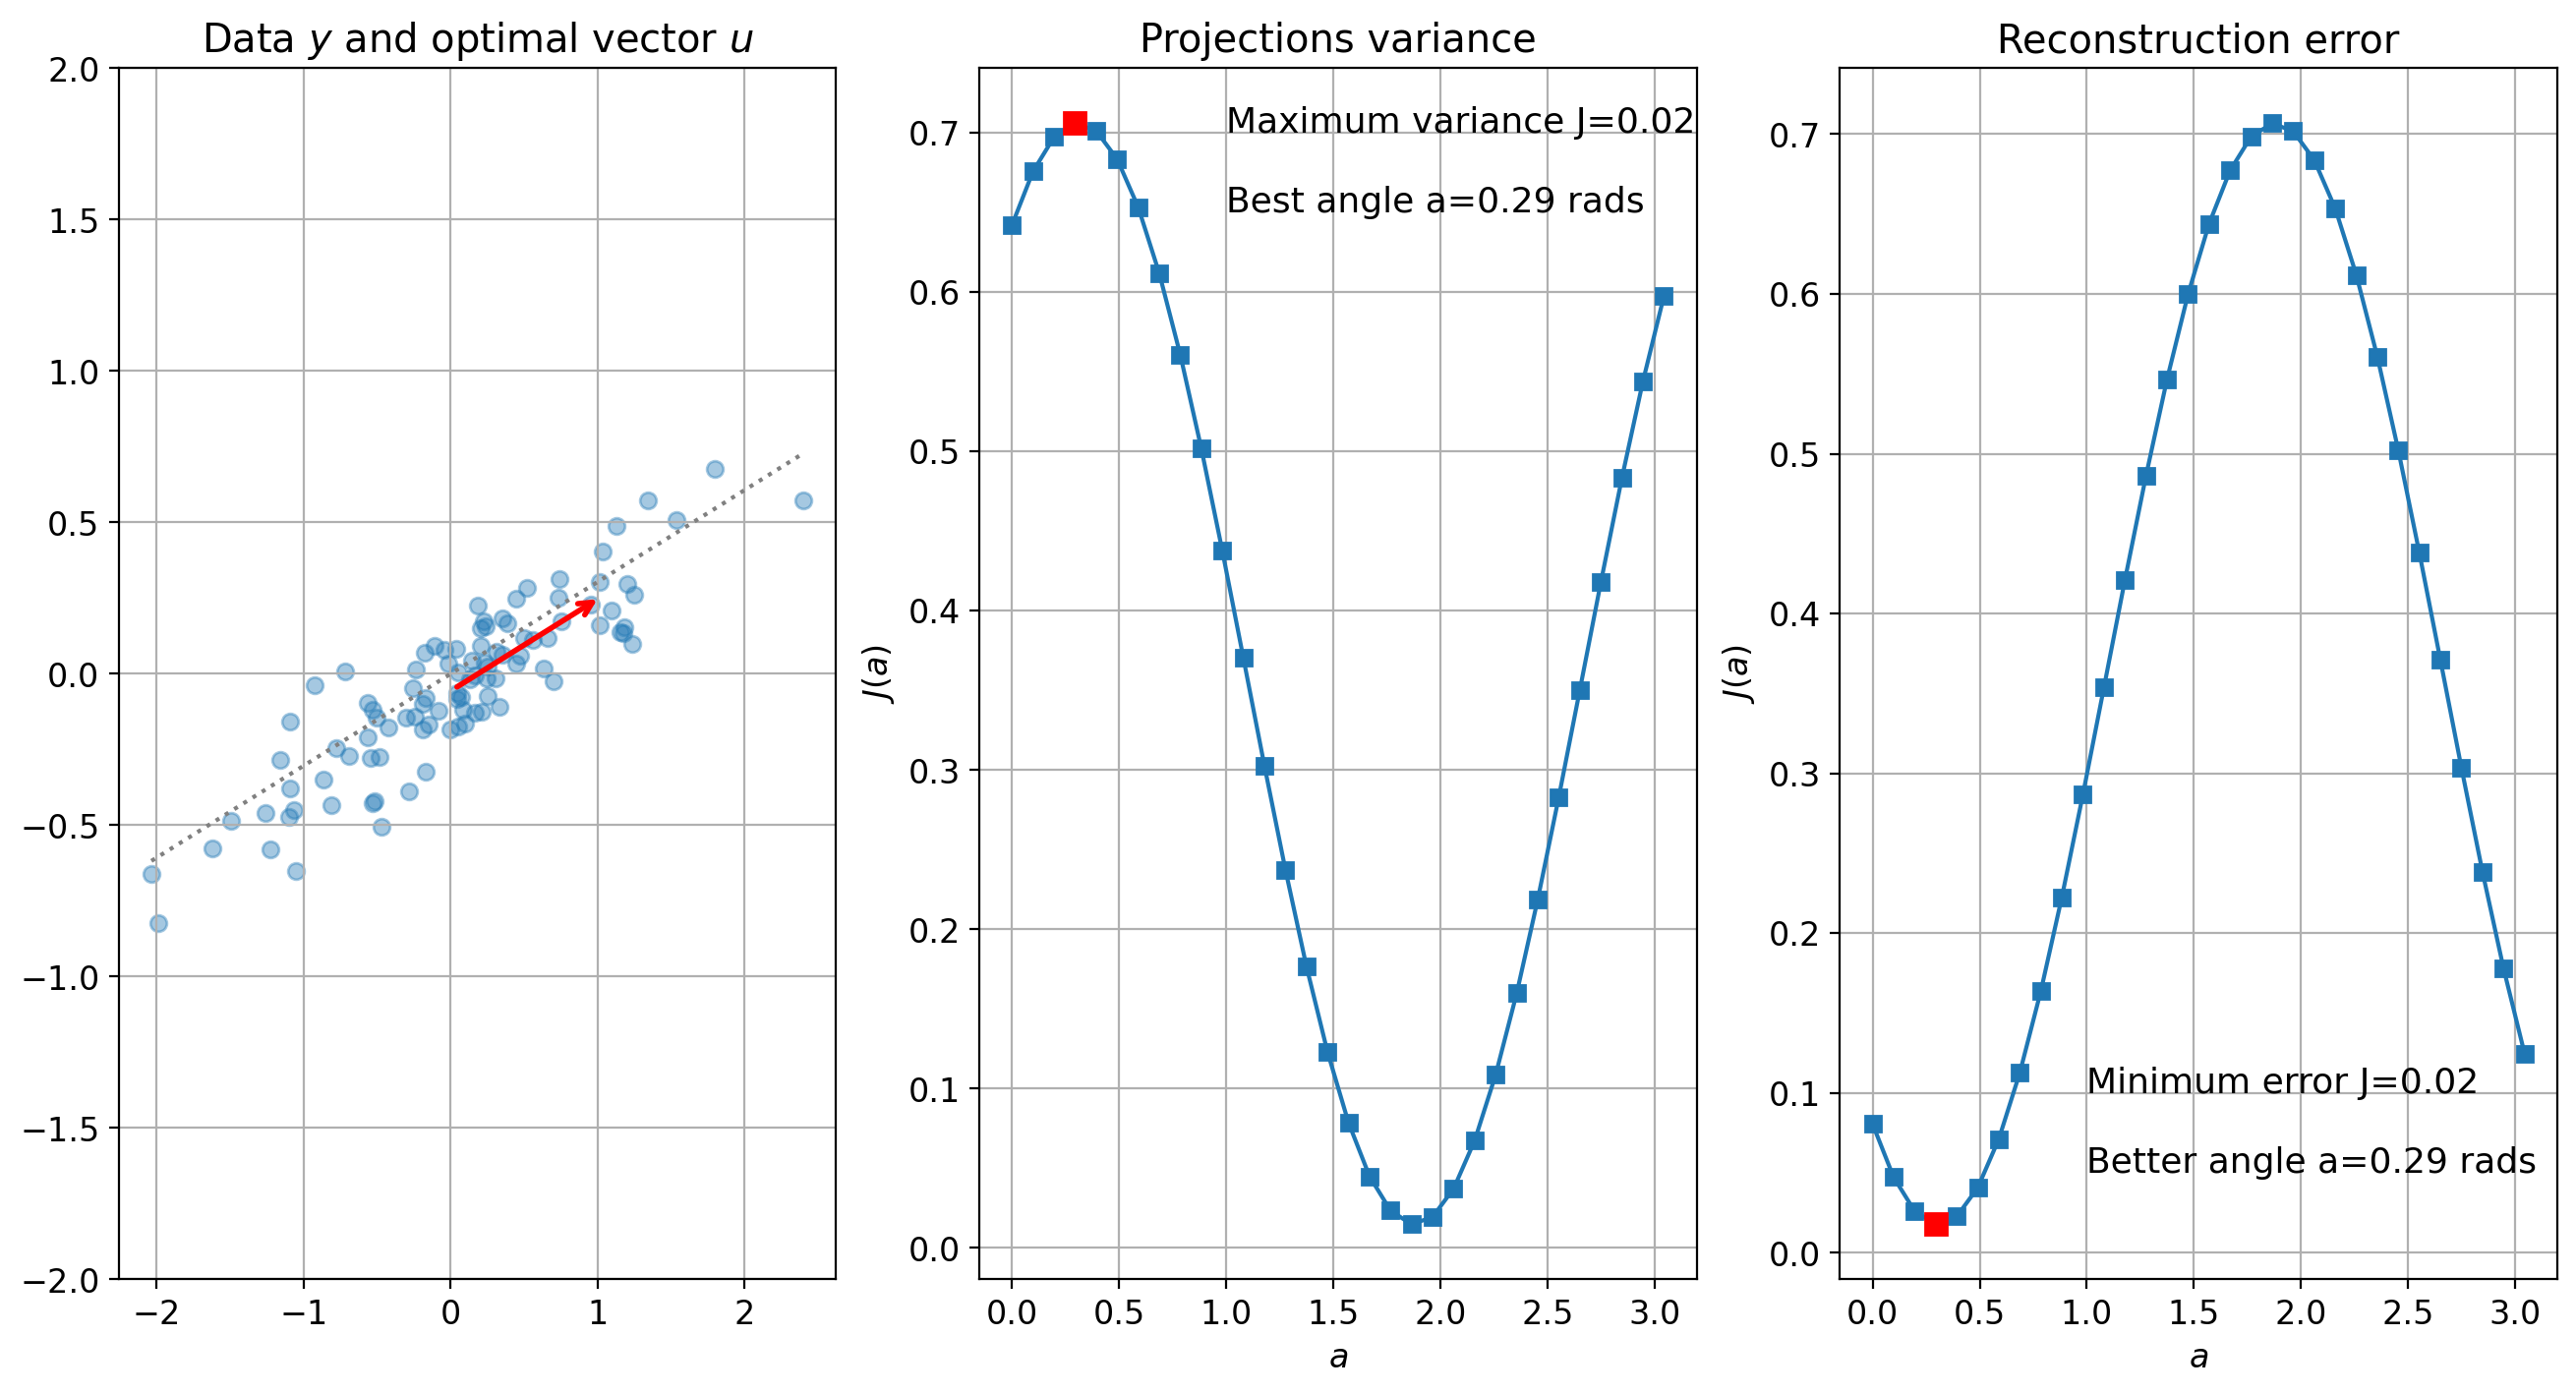

In [5]:
# Define the angles for all the possible vectors u
a_vector = np.arange(0,1,1./32)*np.pi

variance = []

J = []

for i,a in enumerate(a_vector):
    u = np.array([np.cos(a),np.sin(a)]).reshape([-1,1]) # Cartesian coords

    Z = X @ u # Projections over u of the data

    X_r = Z @ u.T

    J.append(np.mean(np.linalg.norm(X-X_r,axis=1)**2))

    variance.append(np.var(Z))

a_opt = a_vector[np.argmin(J)]
u_opt = np.array([np.cos(a_opt),np.sin(a_opt)]).reshape([-1,1])

fig, (ax_l, ax_c, ax_r) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

ax_l.set_ylim([-1,1])
ax_l.scatter(X[:, 0], X[:, 1], alpha=0.4)
ax_l.grid(True)
xgrid=np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax_l.plot(xgrid, xgrid*u_opt[1]/u_opt[0], ':', color='gray')
draw_vector(np.mean(X,axis=0).reshape(2,1), np.mean(X,axis=0).reshape(2,1) + u_opt,ax_l)
ax_l.set_ylim(-2,2)
ax_l.set_title(r"Data $y$ and optimal vector $u$")

ax_c.plot(a_vector,variance,'-s')
ax_c.plot(a_opt,np.max(variance),'rs',ms=8)
ax_c.grid(True)
ax_c.set_xlabel("$a$")
ax_c.set_ylabel("$J(a)$")
ax_c.set_title("Projections variance")
ax_c.text(1., 0.7, 'Maximum variance J={0:.2f}'.format(np.min(J)), fontsize=13)
ax_c.text(1., 0.65, 'Best angle a={0:.2f} rads'.format(a_opt), fontsize=13)

ax_r.plot(a_vector,J,'-s')
ax_r.plot(a_opt,np.min(J),'rs',ms=8)
ax_r.grid(True)
ax_r.set_xlabel("$a$")
ax_r.set_ylabel("$J(a)$")
ax_r.set_title("Reconstruction error")
ax_r.text(1., 0.1, 'Minimum error J={0:.2f}'.format(np.min(J)), fontsize=13)
ax_r.text(1., 0.05, 'Better angle a={0:.2f} rads'.format(a_opt), fontsize=13)

plt.show()

We corroborate that the **minimum reconstruction error is obtained for the vector that induces the high variance in the projected space**. In PCA the goal is to obtain the matrix $\bf U$ that leads to a maxmization of the projected variance, which, as we have seen, minimizes the reconstruction error.


## 2. The PCA algorithm

The PCA solution is the set of principal components that maximize the variance in the projections of the data. Concretely, the solution is computed with the following steps:

- The first principal component, determined by vector $\mathbf{u}_1$, is the one that maximizes the variance of the data projected on $\mathbf{u}_1$:

$$ \max _{\mathbf{u}_1} \frac{1}{N} \sum_{n=1}^{N} (z_{n,1})^2 = \max _{\mathbf{u}_1} \frac{1}{N} \sum_{n=1}^{N} (\mathbf{x}^T_{n}\mathbf{u}_{1})^2$$

- The second principal component, determined by vector $\mathbf{u}_2$, is the **orthonormal** to component $\mathbf{u}_1$ that maximizes the variance of the data projected on $\mathbf{u}_2$:


$$ \max _{\mathbf{u}_2} \frac{1}{N} \sum_{n=1}^{N} (\mathbf{x}^T_{n}\mathbf{u}_{2})^2 \text{ with } \mathbf{u}_1^T\mathbf{u}_2=0$$

- The third principal component, determined by vector $\mathbf{u}_3$, is the **orthonormal** to components $\mathbf{u}_1$ and $\mathbf{u}_2$ that maximizes the variance of the data projected on $\mathbf{u}_3$:

$$ \max _{\mathbf{u}_3} \frac{1}{N} \sum_{n=1}^{N} (\mathbf{x}^T_{n}\mathbf{u}_{3})^2 \text{ tal que } \mathbf{u}_1^T\mathbf{u}_3=0 \text{ y } \mathbf{u}_2^T\mathbf{u}_3=0$$

- This procedure is repeated recurrently until finding the $K$ principal components.


## 2.1. Choosing the number of components

In the last example we have used $K=2$ with the aim at visualizing the PCA projection. A typical approach for choosing the number of components is by obtaining the **explained variance** ratio, given by:

$$F(k) = \frac{\sum_{j=1}^{k}\lambda_j}{\sum_{j=1}^{K} \lambda_j}$$

where the denominator is the sum of all the eigenvalues of the covariance matrix, and it's called the **total variance** and the numerator is the explained variances by the first $k$ principal components. Normally, we find the $k$ for which $F(k)$ surpass the $90\%$ or $95\%$.

**Typically this expression is used with $K=D$ for validating how many principal components are needed for covering a desired percentage of the explained variance.**

## 2.2. PCA Solution

- It can be proved that the principal components $\mathbf{u}_{1},\mathbf{u}_{2},\ldots,\mathbf{u}_{K}$ correspond to the $K$ **eigenvectors** of the covariance matrix $C_{\mathbf{X},\mathbf{X}}$. If the data has zero mean, $C_{\mathbf{X},\mathbf{X}}$ can be obtained using:

$$C_{\mathbf{X},\mathbf{X}} = \frac{1}{N} \sum_{n=1}^N \mathbf{x}_{n}\mathbf{x}_{n}^T$$

- The explained variance within each dimension coincides with the corresponding **eigenvalue**. Therefore, the higher is the eigenvalue, the higher importance the dimension is wrt to explaining the data. The implementation of [PCA in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) gives us the PCA solution with decreasing order of the eigenvalue, and thus, the first component is the most important.

- Finally, it can be demonstrated that the PCA solution is the one that minimizes the mean square reconstruction error:

$$J = \frac{1}{N}\sum_{n=1}^{D} ||\mathbf{x}_n - \tilde{\mathbf{x}}_n||^2_2 =\frac{1}{N}\sum_{n=1}^{D} ||\mathbf{x}_n - \mathbf{U}\mathbf{z}_n^T||^2_2$$.


## 2.3. Scikit-learn implementation

You have an [implementation of PCA in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). You can access to the vectors $\mathbf{u}_1$ and $\mathbf{u}_2$ using `pca.components_`, being a principal component each row of the obtained matrix $\bf U$.


In [6]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(X)

print(pca.components_)

[[ 0.95257252  0.30431168]
 [-0.30431168  0.95257252]]


**We can obtain the variance for each principal component using $\lambda_j=$<code>explained_variance_[n]</code>.**

In [7]:
# Variance computed from data projections:
projections = pca.transform(X)  # Projected data onto u1 and u2
for n in range(n_components):
    print("Variance on projections over the component {0:d} : {1:.2f}".format(n,np.var(projections[:,n])))

# Variance obtained from sklearn object:
print('using sklearn:')
for n in range(n_components):
    var = pca.explained_variance_[n]
    print("Variance on projections over the component {0:d} : {1:.2f}".format(n,var))



Variance on projections over the component 0 : 0.71
Variance on projections over the component 1 : 0.01
using sklearn:
Variance on projections over the component 0 : 0.71
Variance on projections over the component 1 : 0.01


We can plot the resulting principal componentes obtained from sklearn, and plot the transformed space (just for visualization, as in this case $D=K$). Normally, PCA is used for dimensionality reduction when $K<<D$.

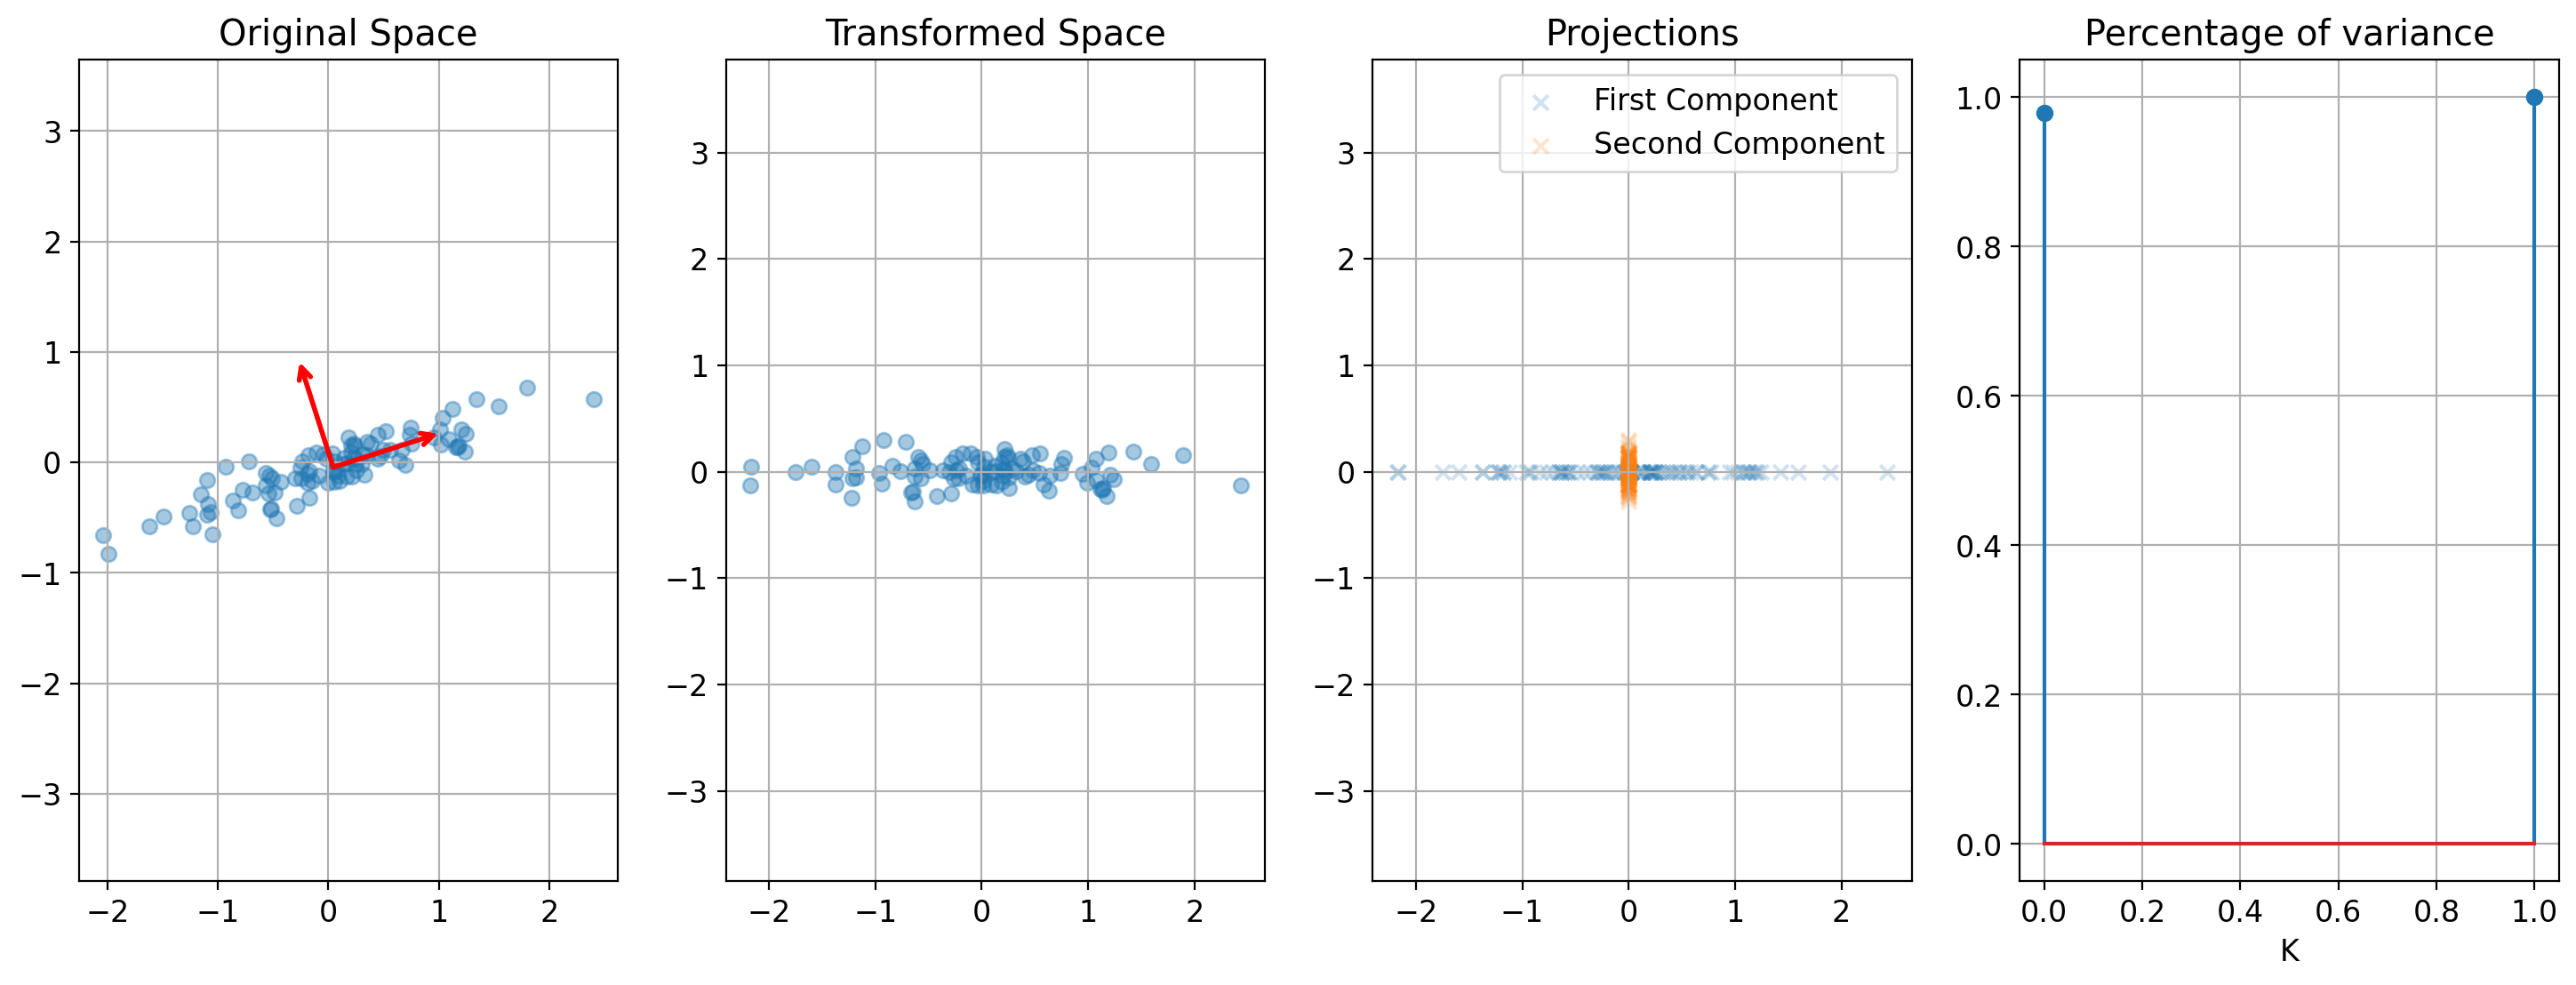

In [8]:
# plot data
f, axs = plt.subplots(1,4, figsize=(18, 6))
axs[0].scatter(X[:, 0], X[:, 1], alpha=0.4)
axs[0].grid(True)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector
    draw_vector(pca.mean_, pca.mean_ + v, axs[0])
axs[0].axis('equal')
axs[0].set_title('Original Space')

Z = pca.transform(X)
axs[1].scatter(Z[:, 0], Z[:, 1], alpha=0.4)
axs[1].grid(True)
axs[1].axis('equal')
axs[1].set_title('Transformed Space')

axs[2].scatter(Z[:, 0], np.zeros_like(Z[:, 0]), marker='x', alpha=0.2, label='First Component')
axs[2].scatter(np.zeros_like(Z[:, 1]), Z[:, 1], marker='x', alpha=0.2, label='Second Component')
axs[2].grid(True)
axs[2].axis('equal')
axs[2].legend(loc='best')
axs[2].set_title('Projections')

variances = [np.var(Z[:, i]) for i in range(Z.shape[-1])]
explained_variances = np.cumsum(variances) / np.sum(variances)
axs[3].stem(explained_variances)
axs[3].set_xlabel('K')
axs[3].set_title('Percentage of variance')
axs[3].grid(True)

plt.show()


# 3. Experiments

## 3.1. Visualizing a wine dataset

In this experiment, you will reduce the dimensionality of a [wine dataset](https://www.kaggle.com/sgus1318/winedata), composed by data from $N=6497$ wines, from $D=12$ to $K=2$, in order to build a map that lets you visualize the whole dataset.

**TASK1: use the PCA implementation of sklearn to reduce the dataset and plot a map with the transformed data $\bf Z$, using the corresponding color of each wine.**

**TASK2: Implement a function for obtaining the explained variance ratio for each number of principal components. Use a stem plot to represent this values. The function must return a vector F_k with the ratio for each component k.*Hint: If data has dimension $D$, F_k should have dimension $D$.***



In [9]:
# Load wine data
data = pd.read_csv('wines.csv', index_col=0)
print(data.shape)
data.head()


(6497, 11)


,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,,,,,,,,,,,
7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [20]:
X = data.values[:, :-1].astype(float)
Y = data.values[:, -1]

# Normalize data
transformer = StandardScaler().fit(X)
Xn = transformer.transform(X)

4601


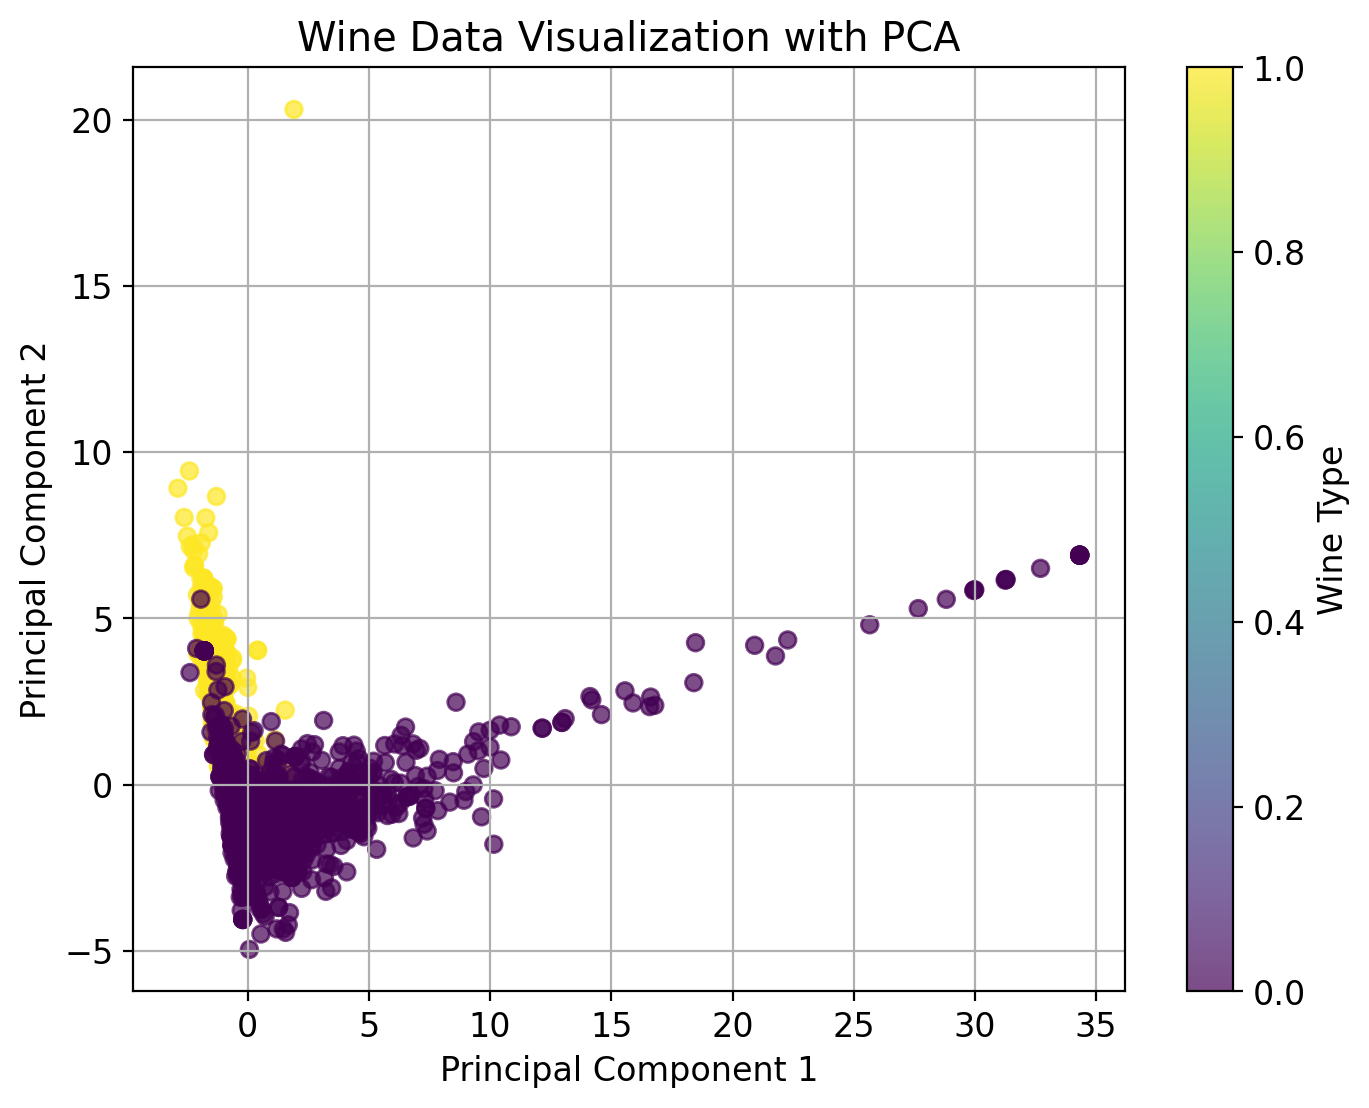

In [21]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the normalized data
pca.fit(Xn[:len(Y)])

# Transform the data to the principal component space
Z = pca.transform(Xn)

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Wine Data Visualization with PCA')
plt.colorbar(label='Wine Type')
plt.grid(True)
plt.show()

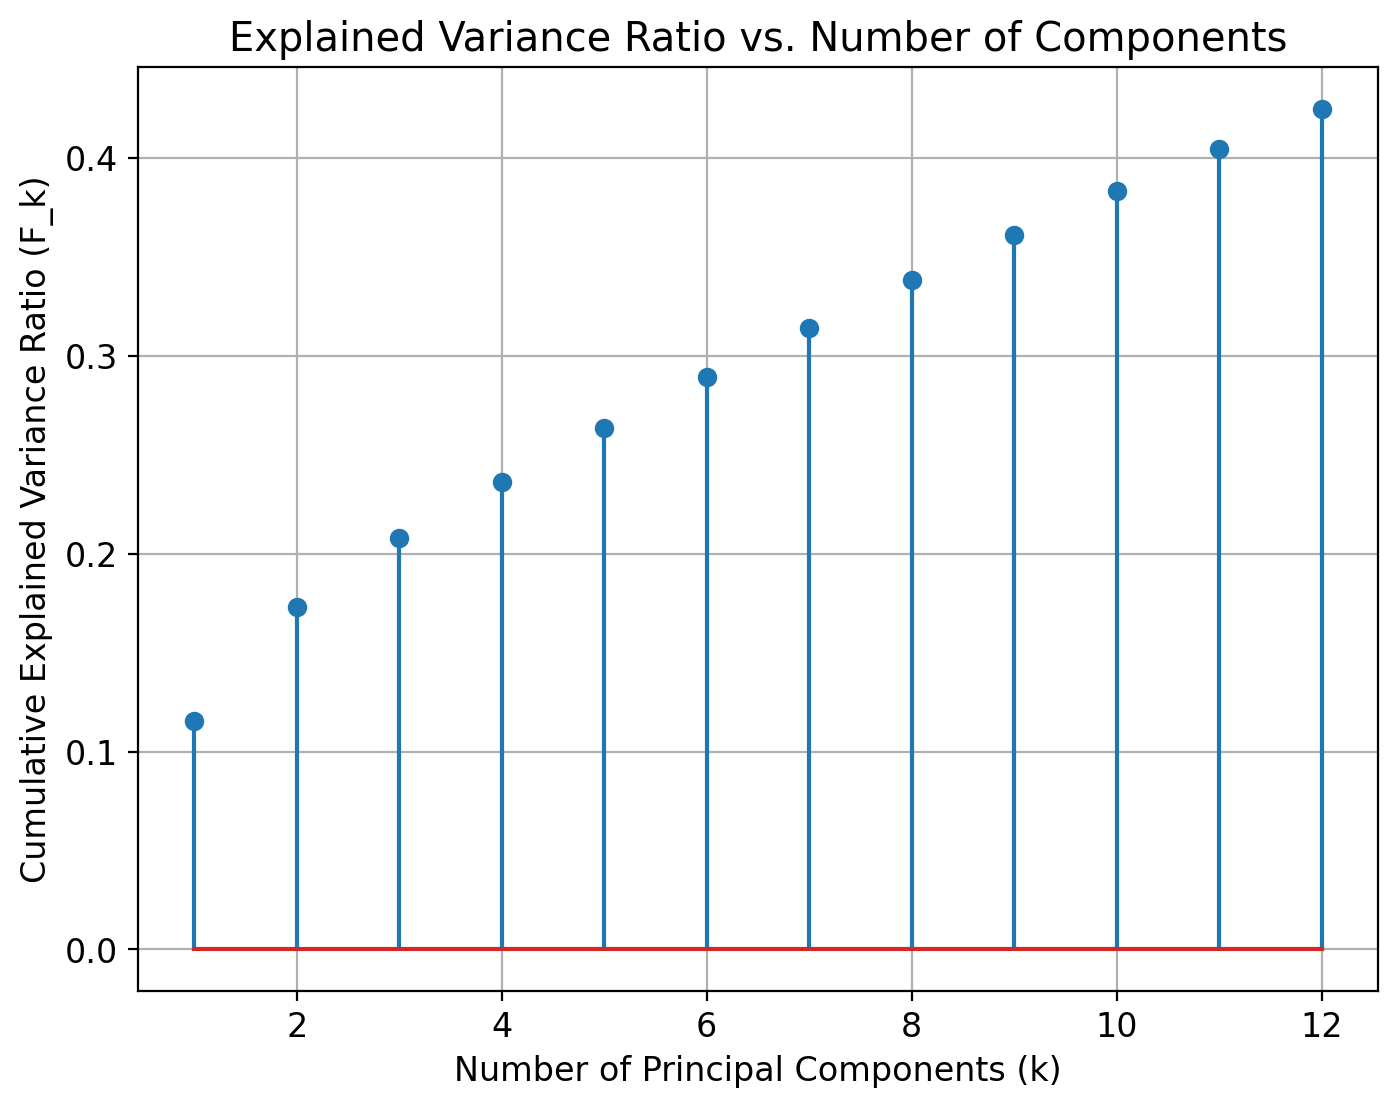

F_k values: [0.11564794 0.17297118 0.2081142  0.23641524 0.26354169 0.28920029
 0.314007   0.33812839 0.36085269 0.38325521 0.4046048  0.42443115]


In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def explained_variance_ratio_plot(data, max_components=None):
  """
  Calculates and visualizes the explained variance ratio for each number of principal components.

  Args:
    data: The input data.
    max_components: The maximum number of components to consider.
                     Defaults to the number of features in the data if None.

  Returns:
    F_k: A vector containing the explained variance ratio for each component.
  """

  # Determine the maximum number of components
  if max_components is None:
    max_components = min(data.shape)  # Use the smaller dimension

  # Initialize an array to store the explained variance ratios
  F_k = np.zeros(max_components)

  # Calculate explained variance ratio for each number of components
  for k in range(1, max_components + 1):
    pca = PCA(n_components=k)
    pca.fit(data)
    F_k[k - 1] = np.sum(pca.explained_variance_ratio_)  # Accumulate explained variance

  # Create a stem plot
  plt.figure(figsize=(8, 6))
  plt.stem(range(1, max_components + 1), F_k, markerfmt='o')
  plt.xlabel('Number of Principal Components (k)')
  plt.ylabel('Cumulative Explained Variance Ratio (F_k)')
  plt.title('Explained Variance Ratio vs. Number of Components')
  plt.grid(True)
  plt.show()

  return F_k

  # Assuming 'Xn' is your normalized data
F_k_values = explained_variance_ratio_plot(Xn, max_components=12)  # Set max_components as needed

# Print the F_k values
print("F_k values:", F_k_values)

## Questions


**1. Could you guess the type of a wine by visualizing its PCA projection?**.
- Your answer.

**2. Given the plot with the explained variances, do you think that all the features of the wines dataset are indispensable?**
- Your answer


## 3.2. PCA Feature Extraction

Another common uses of PCA is the dimensionality reduction of data before the input to a regressor or classifier, which might reduce the overfitting due to the high dimension, and reduce the computational charge.

In this experiment, we use the [Spam Database](https://archive.ics.uci.edu/ml/datasets/Spambase), a dataset with spam indicators oriented to classify spam mail. Each feature is an indicator of the frequency that a word appear in the mail. Using PCA, we will reduce the dimension of the data and improve the classifer in the test set.



In [25]:
def load_spam():
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data',header=None)
    data.columns=["wf_make",
        "wf_address",
        "wf_all",
        "wf_3d",
        "wf_our",
        "wf_over",
        "wf_remove",
        "wf_internet",
        "wf_order",
        "wf_mail",
        "wf_receive",
        "wf_will",
        "wf_people",
        "wf_report",
        "wf_addresses",
        "wf_free",
        "wf_business",
        "wf_email",
        "wf_you",
        "wf_credit",
        "wf_your",
        "wf_font",
        "wf_000",
        "wf_money",
        "wf_hp",
        "wf_hpl",
        "wf_george",
        "wf_650",
        "wf_lab",
        "wf_labs",
        "wf_telnet",
        "wf_857",
        "wf_data",
        "wf_415",
        "wf_85",
        "wf_technology",
        "wf_1999",
        "wf_parts",
        "wf_pm",
        "wf_direct",
        "wf_cs",
        "wf_meeting",
        "wf_original",
        "wf_project",
        "wf_re",
        "wf_edu",
        "wf_table",
        "wf_conference",
        "cf_;",
        "cf_(",
        "cf_[",
        "cf_!",
        "cf_$",
        "cf_#",
        "cap_average",
        "cap_longest",
        "cap_total",
        "target"]
    return data

data = load_spam()

X = data[data.columns[:57]].values
Y = data['target'].values


# Divide into train/test set
X_tr, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Normalize data
transformer_spam = StandardScaler().fit(X_tr)
Xn_tr = transformer_spam.transform(X_tr)
Xn_test = transformer_spam.transform(X_test)

print("Loaded {0:d} obsevations with {1:d} columns\n".format(len(data), len(data.columns)))

# We reduce to 100 the number of observations, to make the problem computationally affordable
Xn_tr = Xn_tr[:100,:]
Y_tr = Y_tr[:100]

data.head()

Loaded 4601 obsevations with 58 columns



,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,...,cf_;,cf_(,cf_[,cf_!,cf_$,cf_#,cap_average,cap_longest,cap_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We are going to validate and train a KNN clasiffier on the first 100 samples

In [14]:
from sklearn import neighbors

# Training a k-NN con validación de vecinos

K_max = 15
rang_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
dict_params = [{'n_neighbors': rang_K,'weights':['uniform','distance']}]

# Cross Validation
knn_spam = GridSearchCV(estimator=neighbors.KNeighborsClassifier( ), param_grid=dict_params,cv=nfold)

# Training
knn_spam.fit(Xn_tr,Y_tr)

# Test
accuracy_train_knn = knn_spam.score(Xn_tr,Y_tr)
accuracy_test_knn = knn_spam.score(Xn_test,Y_test)

print("Number of selected neighbors k={0:d}".format(knn_spam.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))



Number of selected neighbors k=5
Accuracy train 87.00%. Accuracy test 81.10%



**TASK: obtain the best $K$ that maximizes the test accuracy after applying PCA.**

In [26]:
!pip install scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Assuming Xn and Y are already defined

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Xn, Y, test_size=0.2, random_state=42)

# Create the pipeline
pipe = Pipeline([('PCA', PCA()),
                 ('kNN', KNeighborsClassifier())])

# Define the parameter grid for GridSearchCV
param_grid = {
    'PCA__n_components': range(1, X_train.shape[1] + 1),  # Search for best K
    'kNN__n_neighbors': range(1, 20),  # Search for best number of neighbors
    # You can add other hyperparameters to tune if needed
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the final model on the test set
test_accuracy = grid_search.score(X_test, Y_test)
print(f"Test Accuracy with best parameters: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'PCA__n_components': 15, 'kNN__n_neighbors': 11}
Best Accuracy: 0.9179
Test Accuracy with best parameters: 0.9153


It's important to notice that, for this application, the number of components that maximizes the accuracy does not have to coincide with the number of components that explain a certain variance.

**TASK: Obtain the number of components that explain a $90\%$ of the variance of the train set. Compute the explained variance the number of components obtained in the previous experiment.**

In [27]:
from sklearn.decomposition import PCA

# Initialize PCA and fit to the training data
pca = PCA()
pca.fit(Xn_tr)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components explaining 90% variance
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1

print(f"Number of components explaining 90% variance: {n_components_90}")

Number of components explaining 90% variance: 25


In [30]:
for i in range(X.shape[0]):
  # Calculate explained variance for the first 4 components
  explained_variance_4 = cumulative_variance_ratio[i]  # Index 3 corresponds to 4 components

  print(f"Explained variance for {i} components: {explained_variance_4:.4f}")

Explained variance for 0 components: 0.1278
Explained variance for 1 components: 0.2171
Explained variance for 2 components: 0.2983
Explained variance for 3 components: 0.3726
Explained variance for 4 components: 0.4253
Explained variance for 5 components: 0.4758
Explained variance for 6 components: 0.5129
Explained variance for 7 components: 0.5491
Explained variance for 8 components: 0.5842
Explained variance for 9 components: 0.6165
Explained variance for 10 components: 0.6464
Explained variance for 11 components: 0.6758
Explained variance for 12 components: 0.7033
Explained variance for 13 components: 0.7294
Explained variance for 14 components: 0.7554
Explained variance for 15 components: 0.7773
Explained variance for 16 components: 0.7959
Explained variance for 17 components: 0.8127
Explained variance for 18 components: 0.8285
Explained variance for 19 components: 0.8433
Explained variance for 20 components: 0.8575
Explained variance for 21 components: 0.8699
Explained variance f

IndexError: index 57 is out of bounds for axis 0 with size 57

Okay, let's refine your answers to the questions, particularly focusing on improving the response to question 3.

Here's a revised version of your answers:

1. How many components cover the 90% of the explained variance?

25 (Assuming this is the result you obtained from your code). This is correct.
2. What percentage of explained variance cover the first 4 principal components?

0.37 (Assuming this is the result you obtained from your code). This is correct. It indicates that the first 4 principal components capture approximately 37% of the total variance in the data.

## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

